# DESCRIPTION OF THE METHOD
The following work is an implementation of a Time Series Data Generator.
The model name is PSA-GAN, which stands for Progressive Self-Attention GAN. In particular, the model is composed by two elements, 
the Generator and the Discriminator; the architecture of the latter mirrors the architecture of the first.
The generator takes as input a batch of sequences concatenated to a noise vector and an embedding of the sequences themselves, 
then it maps the concatenated matrix into a latent space of smaller size, and then the network produces future sequences of size smaller 
or equal to the one of the input.
The generator contains n blocks where each doubles the size of the output, by linear interpolation. 
Each block is composed by the following functions:
1. upscaling
2. main block
3. concatenation with the time features matrix

The main block is composed by:
- 1d convolution
- Spectral Normalization
- Leaky ReLU
- Residual Self-Attention

The residual self-attention is regulated by a parameter called gamma, and it starts from zero and its absolute value increases in time, 
as the network learns more "distant" features over time. 
This mechanism saves memory compared to networks that use recurrent cells.
The last layer is a 1d convolution which transforms the output from a multivariate sequence to a univariate sequence.

The discriminator 



# IMPORTS

In [1]:
import torch
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import utils
import plotting
import lstm
import metrics
import torch.nn as nn
import progressive_blocks
from sklearn.preprocessing import MinMaxScaler
from torch.utils.data import TensorDataset, DataLoader
from torch.optim import Adam


c:\Users\espda\AppData\Local\Programs\Python\Python310\lib\site-packages\tqdm\auto.py:22: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


# Loading training set
The training dataset is loaded from a local  "*.csv*"  file into a PandasDataset. It consists of time series of monthly data already separated from the test set, with a total of 48000 data.
Then the dataset's features are transformed by using the "*MinMaxScaler*" according to the following formulation:  

$X_{std} = \frac{(X - X.min(axis=0))}{(X.max(axis=0) - X.min(axis=0))} $

$X_{scaled} = X_{std} * (max - min) + min $



Any missing value: V2    False
dtype: bool
all training set length:  48000


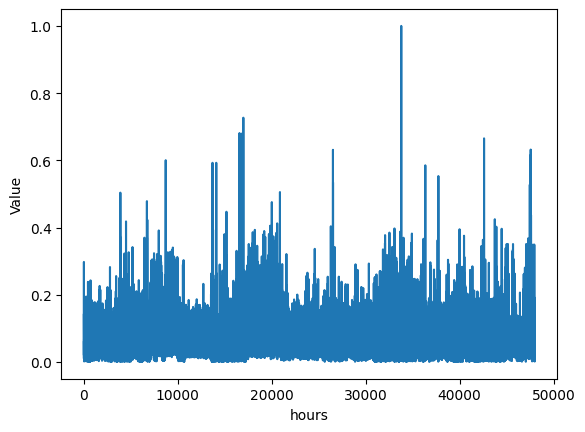

In [2]:
path="Models/M4/"

training_set = pd.read_csv('./Datasets/M4-Dataset/Train/Monthly-train.csv')

training_set = training_set.iloc[:,1:2] #electricity values in time
any_missing_train = training_set.isnull().any()
print("Any missing value:",any_missing_train)
print("all training set length: ",len(training_set))

sc = MinMaxScaler()
training_set = sc.fit_transform(training_set)

plotting.plot_dataset(training_set, x_axis="hours", y_axis="Value")

# Loading Test Set

Any missing value: V2    False
dtype: bool
all testing set length:  48000


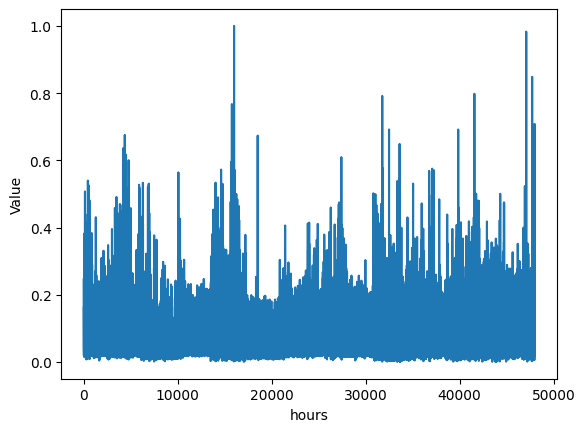

In [3]:

testing_set = pd.read_csv('./Datasets/M4-Dataset/Test/Monthly-test.csv')

testing_set = testing_set.iloc[:,1:2] #electricity values in time
any_missing_test = testing_set.isnull().any()
print("Any missing value:",any_missing_train)
print("all testing set length: ",len(testing_set))

sc = MinMaxScaler()
testing_set = sc.fit_transform(testing_set)

plotting.plot_dataset(testing_set, x_axis="hours", y_axis="Value")

## Creating sequences train

In [4]:
seq_length = 512 #it is tau in the paper

train_set=training_set[:42500]
print("train_set.shape:",train_set.shape)

x_train, y_train = utils.sliding_windows(train_set, seq_length)
trainX=torch.Tensor(np.array(x_train))
print("trainX.shape:",trainX.shape)
size=trainX.size(0)

sequences_train=utils.real_seq(training_set,seq_length)
sequences_train=sequences_train[:size]

sequences_train=torch.Tensor(sequences_train)
sequences_train.unsqueeze(0).unsqueeze(1)
sequences_train=sequences_train.permute(0,2,1)
print("Sequences_train.shape",sequences_train.shape)


train_set.shape: (42500, 1)
trainX.shape: torch.Size([41987, 512, 1])
Sequences_train.shape torch.Size([41987, 1, 512])


## Creating sequences test

In [5]:

test_set=testing_set[:42500]
print(test_set.shape)

x_test, y_test= utils.sliding_windows(test_set, seq_length)
testX=torch.Tensor(np.array(x_test))
print("testX.shape:",testX.shape)
size=testX.size(0)

sequences_test=utils.real_seq(testing_set,seq_length)
sequences_test=sequences_test[:size]

sequences_test=torch.Tensor(sequences_test)
sequences_test.unsqueeze(0).unsqueeze(1)
sequences_test=sequences_test.permute(0,2,1)
print("Sequences_test.shape",sequences_test.shape)



(42500, 1)
testX.shape: torch.Size([41987, 512, 1])
Sequences_test.shape torch.Size([41987, 1, 512])


In [6]:

utils.create_folder(path)
#embedder=torch.load(path+'M4_embedder.pt')

Directory already exists: Models/M4/


# *TRAIN*

In [7]:

def train_GAN(
    trainX,
    sequences_train,
    seq_length,
    batch_size,
    discriminator_lr,
    generator_lr,
    num_epochs,
    blocks_to_add,
    timestamp,
    ml,
    fade_in,
    sa,
    save,
    name,
    gpu,
    path,
):
    embedding_dim=10
    value_features=1
    key_features=1

    #extract the number of features
    num_features=trainX.size(2)+10

    criterion = nn.MSELoss()

    device=utils.assign_device(gpu)

    #Initializations
    train = TensorDataset(trainX, sequences_train)
    train_loader = DataLoader(train, batch_size=batch_size, shuffle=False) 

    
    D=progressive_blocks.Discriminator(embedding_dim,seq_length,num_features,batch_size,value_features,key_features,sa,device)
    G=progressive_blocks.Generator(embedding_dim,seq_length,num_features,batch_size,value_features,key_features,sa,device)
    optimD = Adam(D.parameters(), lr=discriminator_lr, betas=(0.9, 0.999))
    optimG = Adam(G.parameters(), lr=generator_lr, betas=(0.9, 0.999))
    #embedder=lstm.LSTMEncoder().to(device)
    embedder=torch.load("Models/Embedder/embedder_model.pt").to(device)

    activeG=(G.step-1)-blocks_to_add
    activeD=blocks_to_add

    utils.create_folder(path+'/'+name+'/')

    #Training
    g_losses = []
    d_losses = []
    fids = []
    G.to(device)
    D.to(device)
    fade=1
    sum_fade=0
    g_loss_min=1000000
    d_loss_min=1000000

    print()
    print("Starting training:",name)
    print("Total Epochs: %d \nBlocks to add with fade: %d\nTimestamp to add blocks: %d" % 
                        (num_epochs, blocks_to_add, timestamp))
    print()
    for epoch in range(1,num_epochs+1):
            g_losses_temp=[]
            d_losses_temp=[]
            fids_temp=[]
            if (epoch%timestamp==0 and epoch!=0 and activeG!=G.step-1 and activeD!=0 and fade_in==True):
                activeD-=1
                activeG+=1
                fade=0
                sum_fade=1/((timestamp)/2)
                print("Block added")

            elif(fade+sum_fade<=1 and fade_in==True):
                fade+=sum_fade

            else:
                fade=1

            for i, (X, Y) in enumerate((train_loader)):
                X=X.to(device)
                Y=Y.to(device)

                # Generate fake data
                fake_data = G(X,fade,activeG)
                fake_label = torch.zeros(Y.size(0))
                
            
                # Train the discriminator
                Y=Y[:,:,:fake_data.size(2)]  #we use this to adapt real sequences length to fake sequences length
            
                D.zero_grad()
                d_real_loss = criterion(D(Y,X,fade,activeD), torch.ones_like(D(Y,X,fade,activeD)))
                d_fake_loss = criterion(D(fake_data.detach(),X,fade,activeD), torch.zeros_like(D(fake_data.detach(),X,fade,activeD)))
                d_loss = d_real_loss + d_fake_loss
                d_losses_temp.append(d_loss.item())
                d_loss.backward(retain_graph=False)
                optimD.step()
                
                # Train the generator
                G.zero_grad()
                g_loss = criterion(D(fake_data,X,fade,activeD), torch.ones_like(D(fake_data,X,fade,activeD)))

                if(ml==True):
                    # Add the moment loss
                    g_loss += utils.moment_loss(fake_data, Y)

                g_losses_temp.append(g_loss.item())

                g_loss.backward()
                optimG.step()
                
                #Compute FID
                with torch.no_grad():
                    fake_embedding=embedder(fake_data)
                    real_embedding=embedder(Y) 
                    fid = metrics.calculate_fid(real_embedding.to("cpu").detach().numpy(), fake_embedding.to("cpu").detach().numpy())
                    
                fids_temp.append(fid)    

                # Print the losses
                if (i+1) % 1 == 0:
                    print("[Epoch %d/%d] [Batch %d/%d] [D loss: %f] [G loss: %f] [Fade-in: %f] [FID: %f]" % 
                        (epoch, num_epochs, i+1, len(train_loader), d_loss.item(), g_loss.item(), fade, fid))
                
                if(g_loss<g_loss_min and d_loss<d_loss_min and save):
                        g_loss_min = g_loss
                        d_loss_min = d_loss
                        torch.save(G, path+name+'/'+name+'_generator.pt')
                        torch.save(D, path+name+'/'+name+'_discriminator.pt')
                        print('Improvement-Detected, model saved')


            g_losses.append(torch.mean(torch.Tensor(g_losses_temp)))
            d_losses.append(torch.mean(torch.Tensor(d_losses_temp)))
            fids.append(torch.mean(torch.Tensor(fids_temp)))
            
    values=['Last G loss: '+str(g_losses[-1].item()), 
            'Last D loss: '+str(d_losses[-1].item()),
            'Last FID: '+str(fids[-1].item()),
            'epochs: '+str(num_epochs),
            'ML: '+str(ml),
            'SA: '+str(sa),
            'Fade-in: '+str(fade),
            'Blocks to add: '+str(blocks_to_add),
            'Timestamp: '+str(timestamp),
            ]
    plotting.plot_training_history('PSA-GAN - M4 - '+name,d_losses, g_losses)
    plotting.plot_fid_history('PSA-GAN - M4 - '+name, fids)
    location=path+'/'+name+'/'+name
    utils.write_file(location, values)

    return D,G, d_losses, g_losses, fids

## Start training

Cuda enabled: using GPU
Directory already exists: Models/M4//psa-gan/

Starting training: psa-gan
Total Epochs: 27 
Blocks to add with fade: 2
Timestamp to add blocks: 9

[Epoch 1/27] [Batch 1/121] [D loss: 0.632341] [G loss: 1.372900] [Fade-in: 1.000000] [FID: 0.002160]
Improvement-Detected, model saved
[Epoch 1/27] [Batch 2/121] [D loss: 0.642743] [G loss: 1.187327] [Fade-in: 1.000000] [FID: 0.001262]
[Epoch 1/27] [Batch 3/121] [D loss: 0.638504] [G loss: 1.090609] [Fade-in: 1.000000] [FID: 0.001001]
[Epoch 1/27] [Batch 4/121] [D loss: 0.632402] [G loss: 1.025176] [Fade-in: 1.000000] [FID: 0.000866]
[Epoch 1/27] [Batch 5/121] [D loss: 0.626179] [G loss: 0.980440] [Fade-in: 1.000000] [FID: 0.000693]
Improvement-Detected, model saved
[Epoch 1/27] [Batch 6/121] [D loss: 0.619836] [G loss: 0.937829] [Fade-in: 1.000000] [FID: 0.000701]
Improvement-Detected, model saved
[Epoch 1/27] [Batch 7/121] [D loss: 0.613416] [G loss: 0.902821] [Fade-in: 1.000000] [FID: 0.000664]
Improvement-Detected

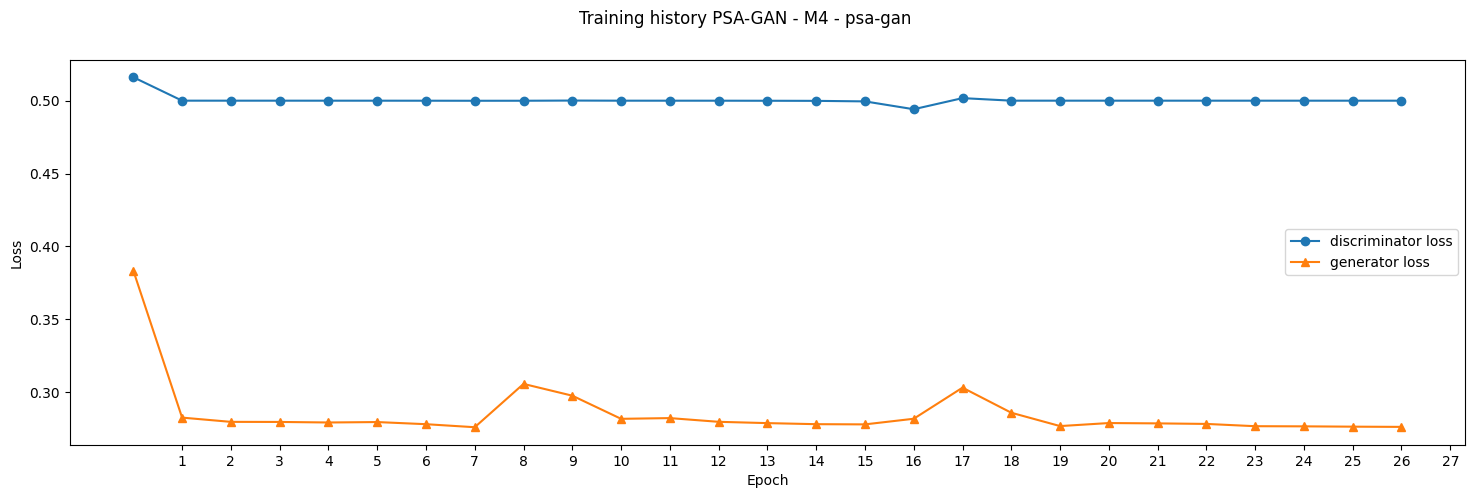

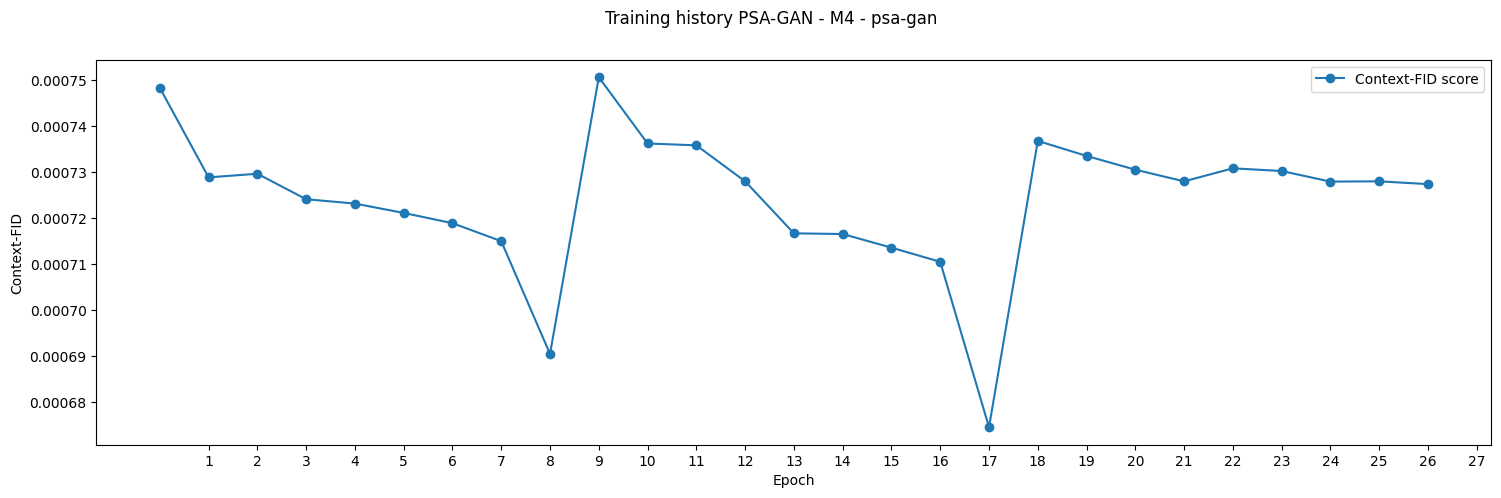

In [8]:
%%time

name_model="PSA-GAN"
D,G, d_losses, g_losses, fids = train_GAN(
    trainX,
    sequences_train,
    seq_length=seq_length,
    batch_size=347,
    #batch_size=121,
    discriminator_lr=0.0005,
    generator_lr=0.0005,
    num_epochs=24,
    #num_epochs=2,
    blocks_to_add=2,
    timestamp=8,
    ml=True,
    fade_in=True,
    sa=True,
    save=True,
    name=name_model,
    gpu=True,
    path=path,
)


LOAD MODEL

In [9]:
name_model="PSA-GAN"
G,D = utils.load_model(path,name_model)

Model Loaded succesfully:  psa-gan


Predictions on the train set


NRMSE on test set:  tensor(0.3245)


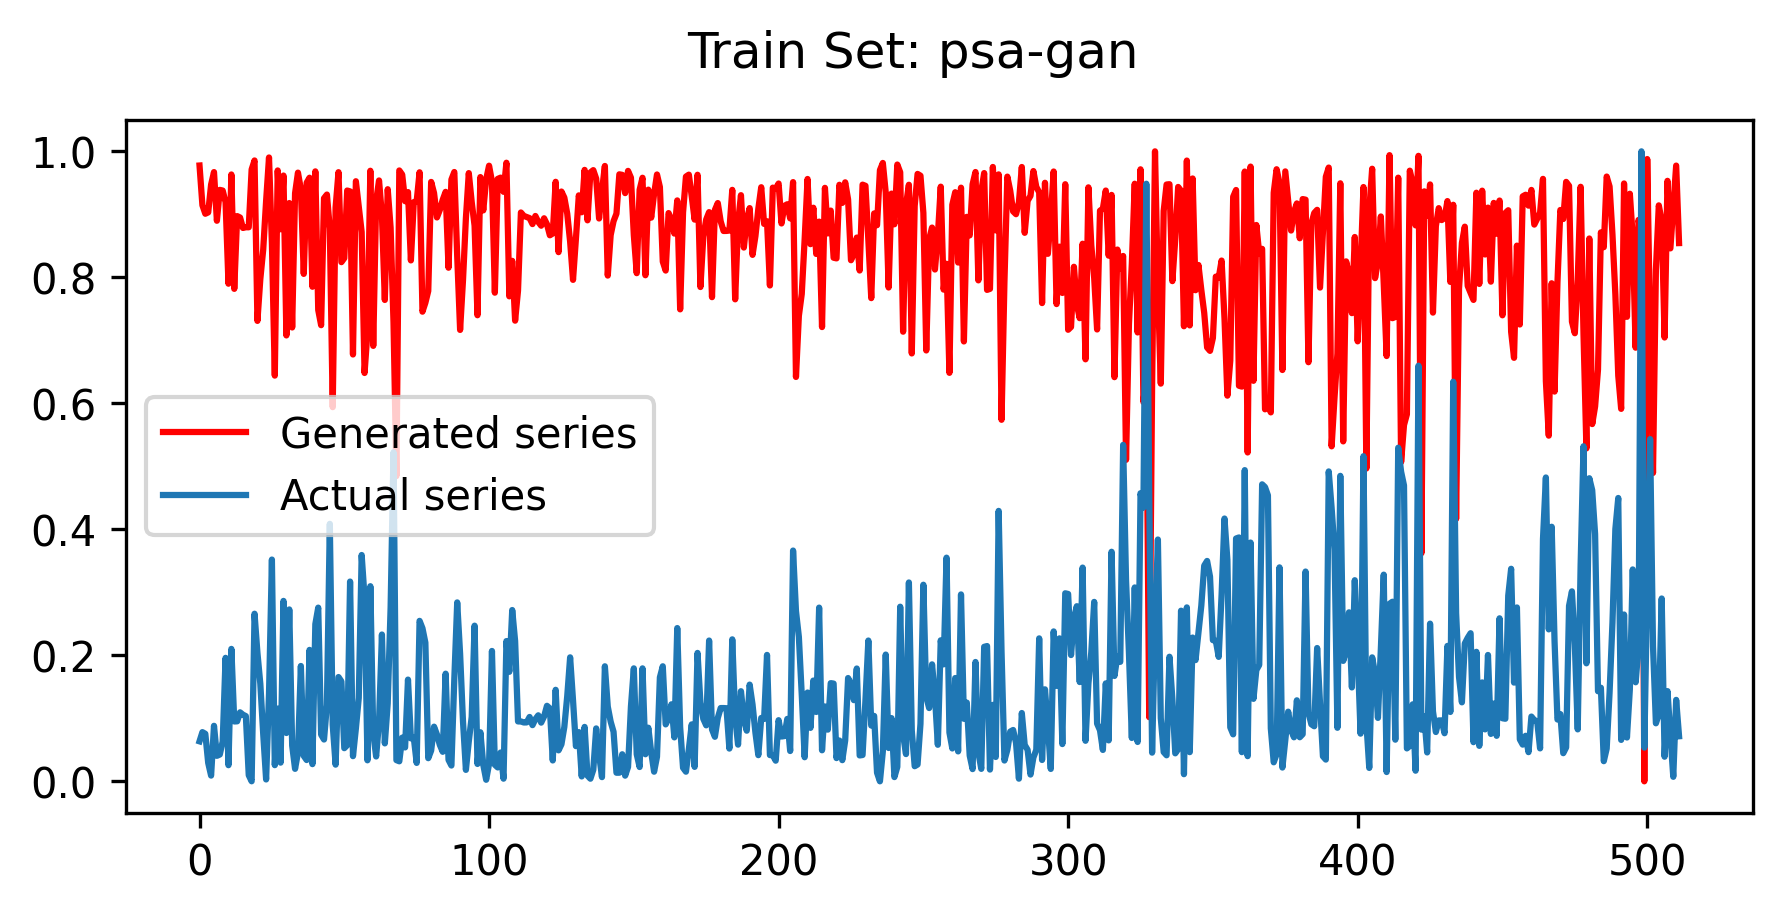

In [10]:
t = train_set[len(trainX):len(trainX)+seq_length]
batch_size=347
#batch_size=121
with torch.no_grad():
    
    generated_series = G(trainX[len(trainX)-batch_size:],1,(G.step-1)) 
    generated_series=generated_series.permute(0,2,1)
    #print("generated_series: ",generated_series.shape)
    generated_series = generated_series.to("cpu").detach().numpy()

generated_series[batch_size-1]=utils.scale(generated_series[batch_size-1])
aux=utils.scale(t)

nrmse=metrics.nrmse(torch.Tensor(generated_series), torch.Tensor(aux))
print("NRMSE on test set: ",nrmse)
plotting.plot_prediction(generated_series[batch_size-1], aux, 'Train Set: ',name_model)



Predictions on the Test set

NRMSE on test set:  tensor(0.3157)


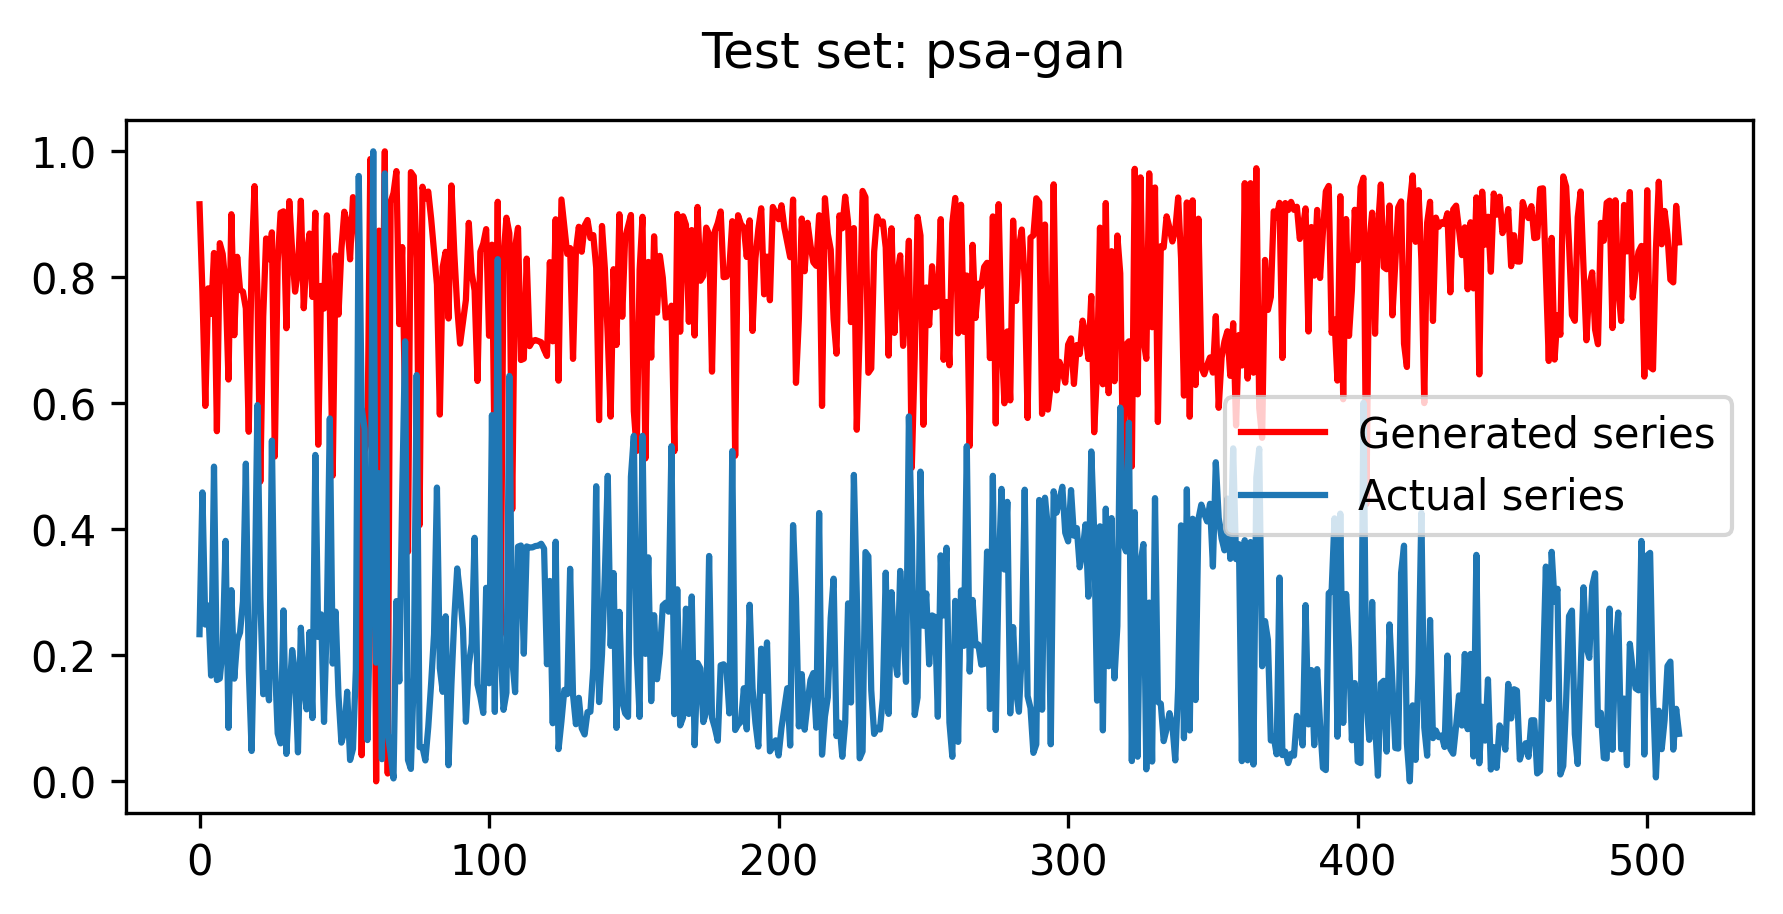

In [11]:

seq_length = 512 #it is tau in the paper

batch_size=347

t = test_set[len(testX):len(testX)+seq_length]

with torch.no_grad():
    
    generated_series = G(testX[len(testX)-batch_size:],1,(G.step-1)) 
    generated_series=generated_series.permute(0,2,1)
    #print("generated_series: ",generated_series.shape)
    generated_series = generated_series.to("cpu").detach().numpy()

generated_series[batch_size-1]=utils.scale(generated_series[batch_size-1])
aux=utils.scale(t)

nrmse=metrics.nrmse(torch.Tensor(generated_series), torch.Tensor(aux))
print("NRMSE on test set: ",nrmse)
plotting.plot_prediction(generated_series[batch_size-1], aux, "Test set: ", name_model)



# Evaluations

In [12]:
name_model="PSA-GAN"
G,D = utils.load_model(path,name_model)
batch_size=347

Model Loaded succesfully:  psa-gan


In [13]:

print("testX.shape",testX.shape)
print("sequence_test",sequences_test.shape)

train = TensorDataset(trainX, sequences_train)
train_loader = DataLoader(train, batch_size=batch_size, shuffle=False)

test= TensorDataset(testX, sequences_test)
test_loader = DataLoader(test, batch_size=batch_size, shuffle=False) 

testX.shape torch.Size([41987, 512, 1])
sequence_test torch.Size([41987, 1, 512])


## NRMSE

In [14]:
nrmse= metrics.evaluate_model(G,test_loader, "NRMSE")
print(name_model," NRMSE:",nrmse)
#NRMSE: 0.0006188842235133052

100%|██████████| 121/121 [00:04<00:00, 27.99it/s]

psa-gan  NRMSE: 0.034538593143224716


## CONTEXT - FID

it means if you sampled 95 data sets you'd expect the true mean to lie in that interval 95 of the time (but you wouldn't know which ones, so you can't say for any specific interval you compute that the mean will be there).

In [15]:
embedder = torch.load("Models/Embedder/embedder_model.pt")
#mean, std_dev, lower, upper = metrics.run_evaluation(G,G,G, test_loader, "FID",0.95, embedder)
mean, std_dev, lower, upper = metrics.run_evaluation1(G, test_loader, "FID", 0.95, embedder)
print("FID =",mean,"+-",upper," \nstd:",std_dev)

100%|██████████| 121/121 [00:51<00:00,  2.36it/s]

FID = 0.0003660239971006568 +- 0.0003660239971006568  
std: 0.0


# MAIN RESULTS